In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import math
import scipy.integrate
import pandas as pd
import seaborn as sb
import sys
sys.path.insert(0, '..')
import cylinder.surfaces_and_fields.system_cylinder as cylinder

firsttime=False

plt.rcParams["figure.figsize"]=6,6
plt.rcParams['font.size'] = '18'

# 1. Limits perturbatively

Plot the linear limit of stability $k_c(\gamma, \kappa)$ obtained from linear stability analysis.

The energy difference is $$ \frac{\Delta \mathcal{H}}{A_0 a^2} = \frac{\gamma}{4} (k^2 r_0^2 -1)+ \frac{\kappa}{8r_0^2} (3 + (4H_0-1) k^2r_0^2 + 2 k^4 r_0^4), $$ setting $r_0 =1$
$$ \frac{\delta \mathcal{H}}{A_0 a^2} = \frac{\gamma}{4} (k^2 -1)+ \frac{\kappa}{8} (3 + (4H_0-1) k^2 + 2 k^4). $$

Solutions are at $$ k_c(g) = \frac{1}{2} \sqrt{1-2g-8h + \sqrt{8(2g-3)+(-1+8h+22g)^2}} $$ with $g=\gamma/\kappa$.

In case of zero spontaneous curvature $h=0$:

$$ k_c(g) = \frac{1}{2} \sqrt{1-2g + \sqrt{8(2g-3)+(-1+22g)^2}}. $$

In [2]:
def kcrit(g,h):
    g+=2*h**2
    discriminant1 =8*(2*g-3)+(-1+8*h+2*g)**2
    #discriminant1 =-23 + 12* g+4 * g**2
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-2*g-8*h +  math.sqrt(discriminant1)
        #print(discriminant2)
        if discriminant2 <0:
            return np.nan
        else:
            return .5*math.sqrt(discriminant2)

In [3]:
gs = list(np.arange(0.001, 10, .001))
gs.extend([1/kappa for kappa in range(1,10)])
gs.extend( [20,50,100,200,500,1000,10000,100000])
gs.sort()
kcrits_ = [kcrit(g, h=0) for g in gs] #generate data

Plot of limit of instability as a function of rising relative surface tension $\gamma$:

(0.0, 4.0)

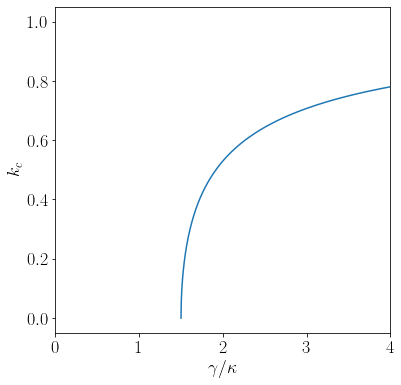

In [4]:
plt.plot([g for g,kc in zip(gs, kcrits_)], [kc for kc in kcrits_])
plt.xlabel(r"$\gamma/\kappa$")
plt.ylabel(r'$k_c$')
plt.xlim(0,4)

Same limit viewed as a function of relative bending rigidity $\kappa$:

(0.0, 1.0)

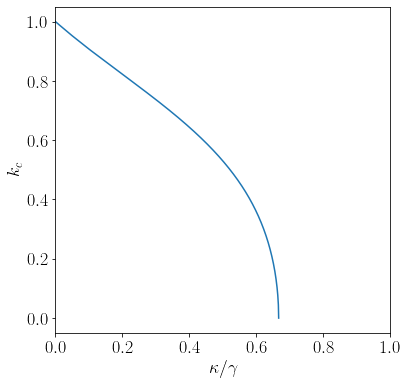

In [5]:
plt.plot([1/g for g,kc in zip(gs, kcrits_)], [kc for kc in kcrits_])
plt.xlabel(r"$\kappa/\gamma$")
plt.ylabel(r'$k_c$')
plt.xlim(0,1)

## 1.2 With Spontaneous curvature

Now try limits of instability with nonzero spontaneous curvatures

(0.0, 10.0)

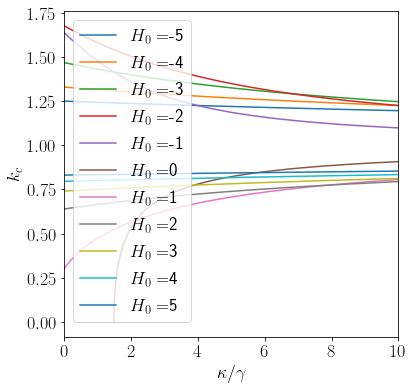

In [6]:
hs = np.arange(-5, 6, 1)
kcrits_h = {} #dict to save all the data
for h in hs:
    kcrits_h[h] = [kcrit(g, h=h) for g in gs]
    plt.plot([g for g in gs], [kc for kc in kcrits_h[h]], label = r'$H_0=$' + str(h))
plt.legend()
plt.xlabel(r"$\kappa/\gamma$")
plt.ylabel(r'$k_c$')
plt.xlim((0,10))

At positive spontaneous curvature $H_0$, the instability is supresses, with longer cylinders (smaller wavenumber $k$) than $k=1$ remaining stable.   Critical bending rigidity remains at the same point $\kappa/\gamma = 3/2$.

At negative spontanous curvatures the cylinder is destablized.

In a $\gamma/\kappa$ view:

(0.0, 1.0)

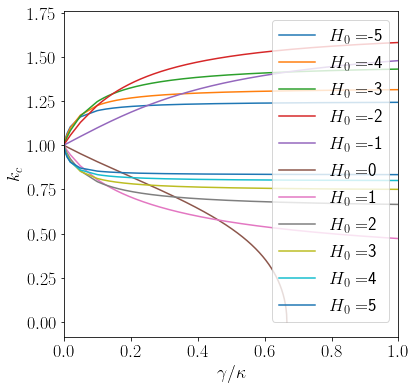

In [7]:
for h in hs:
    plt.plot([1/g for g in gs], [kc for kc in kcrits_h[h]], label = r'$H_0=$' + str(h))
plt.legend()
plt.xlabel(r"$\gamma/\kappa$")
plt.ylabel(r'$k_c$')
plt.xlim((0,1))

Now plot from the angle of varying $H_0$ at some fixed $\gamma/\kappa$

Text(0.5, 0, '$H_0$')

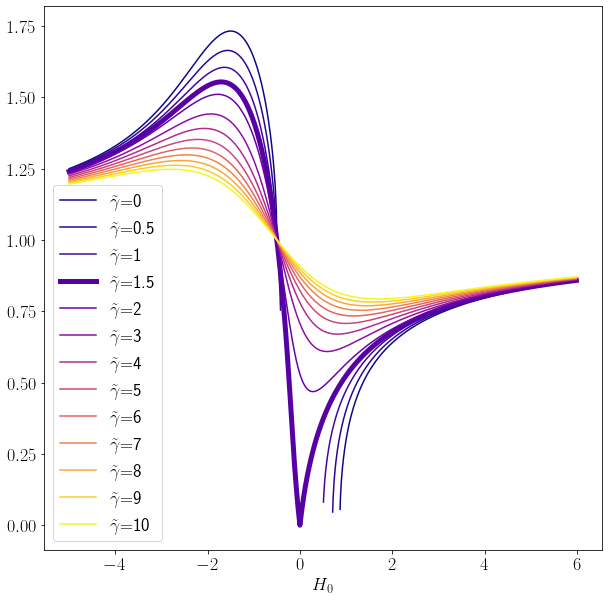

In [8]:
fine_hs = np.arange(-5, 6, .01)
g_ratios = [i for i in np.arange(0,11,1)]
g_ratios.extend([.5,1.5])
g_ratios.sort()
kcrits_rangehs= {} #place to store data
#colorcode
g_ratio_colors = {} 
for g_ratio in g_ratios:
    value=(g_ratio-min(g_ratios))/(max(g_ratios)-min(g_ratios))
    g_ratio_colors[g_ratio]= plt.cm.plasma(value)
    
#plot
plt.figure(figsize=(10,10))    
for g_ratio in g_ratios:
    kcrits_rangehs[g_ratio] = [kcrit(g_ratio,h) for h in fine_hs] #generate data
    if g_ratio == 1.5: #bold the line at critical bending rigidity     
        plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                linewidth=5, c=g_ratio_colors[g_ratio])
    else:
        plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                 c=g_ratio_colors[g_ratio])
plt.legend()
plt.xlabel(r"$H_0$")
#plt.ylim(0,2)

# 2. Minima by numerically integrating

For H_0 =0 : we are going to extract energy of the system for a range of k, kappa, a

In [9]:
a_s = np.arange(-.99, 1, .01)
ks = np.arange(0.005, 1.4, .01)

In [10]:
#generate (or load) curvature integral, surface area of the object for a range of k,a
if firsttime:
    curvenergy = {}
    for k in ks:
        curvenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=1, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            energy=cy.calc_bending_energy(amplitude=a)
            curvenergya[round(a,2)]=energy*k
            #note we are missing a factor of 2pi eveywhere in cylinder AND
            # these are total energies of an object of length 2pi/k, to get comparable energy per length
            # I here multiply by k/2pi
        curvenergy[round(k,4)]=curvenergya
    curvdata = pd.DataFrame(curvenergy)
    curvdata.to_csv("chapter2data/curvenergy_H0_tmp.csv")
else:
    curvdata=pd.read_csv("chapter2data/curvenergy_H0.csv", index_col=0)
print(curvdata)

           0.005      0.015      0.025      0.035      0.045      0.055  \
-0.99  54.369246  54.368804  54.367920  54.366597  54.364834  54.362635   
-0.98  38.414209  38.413795  38.412969  38.411730  38.410081  38.408024   
-0.97  31.340836  31.340444  31.339661  31.338486  31.336923  31.334974   
-0.96  27.121673  27.121298  27.120550  27.119430  27.117938  27.116078   
-0.95  24.240852  24.240493  24.239776  24.238703  24.237273  24.235491   
...          ...        ...        ...        ...        ...        ...   
 0.95  24.240852  24.240493  24.239776  24.238703  24.237273  24.235491   
 0.96  27.121673  27.121298  27.120550  27.119430  27.117938  27.116078   
 0.97  31.340836  31.340444  31.339661  31.338486  31.336923  31.334974   
 0.98  38.414209  38.413795  38.412969  38.411730  38.410081  38.408024   
 0.99  54.369246  54.368804  54.367920  54.366597  54.364834  54.362635   

           0.065      0.075      0.085      0.095  ...      1.305      1.315  \
-0.99  54.360003  5

In [11]:
if firsttime:
    surfenergy = {}
    for k in ks:
        surfenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=1, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            energy=cy.evaluate_A_integral_0(amplitude=a)
            surfenergya[round(a,2)]=energy*k
        surfenergy[round(k,4)]=surfenergya
    #print(surfenergy)
    surfdata = pd.DataFrame(surfenergy)
    print(surfdata)
    surfdata.to_csv("chapter2data/surfenergy_H0_tmp.csv")
else:
    surfdata=pd.read_csv("chapter2data/surfenergy_H0.csv", index_col=0)
print(surfdata)

          0.005     0.015     0.025     0.035     0.045     0.055     0.065  \
-0.99  5.147321  5.147490  5.147829  5.148336  5.149013  5.149859  5.150874   
-0.98  5.164419  5.164586  5.164921  5.165424  5.166094  5.166931  5.167935   
-0.97  5.181512  5.181677  5.182009  5.182506  5.183169  5.183997  5.184991   
-0.96  5.198598  5.198762  5.199090  5.199581  5.200237  5.201056  5.202040   
-0.95  5.215674  5.215836  5.216161  5.216647  5.217295  5.218106  5.219078   
...         ...       ...       ...       ...       ...       ...       ...   
 0.95  5.215674  5.215836  5.216161  5.216647  5.217295  5.218106  5.219078   
 0.96  5.198598  5.198762  5.199090  5.199581  5.200237  5.201056  5.202040   
 0.97  5.181512  5.181677  5.182009  5.182506  5.183169  5.183997  5.184991   
 0.98  5.164419  5.164586  5.164921  5.165424  5.166094  5.166931  5.167935   
 0.99  5.147321  5.147490  5.147829  5.148336  5.149013  5.149859  5.150874   

          0.075     0.085     0.095  ...     1.305 

In [12]:
#search each series A(a) (for each k)
#for the minimum surface area
if firsttime:
    minima_surf = {}
    for k in surfdata.columns:
        energy_vs_a = surfdata.loc[:,k]
        #print(surfdata.loc[:,k])
        min_a = energy_vs_a.idxmin()
        min_energy = energy_vs_a[min_a]
        minima_surf[k]=({"a":min_a, "E":min_energy})
    #print(minima_surf)
    minima_surf_df = pd.DataFrame(minima_surf)
    minima_surf_df.to_csv("chapter2data/minima_surf_tmp.csv", header=True, index=True)
else:
    minima_surf_df=pd.read_csv("chapter2data/minima_surf.csv", index_col=0)
minima_surf_df

,0.005,0.015,0.025,0.035,0.045,0.055,0.065,0.075,0.085,0.095,...,1.305,1.315,1.325,1.335,1.345,1.355,1.365,1.375,1.385,1.395
a,0.990000,0.99000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.99000,0.99000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E,5.147321,5.14749,5.147829,5.148336,5.149013,5.149859,5.150874,5.152057,5.15341,5.15493,...,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185


In [13]:
#same for curvature energy
if firsttime:
    minima_curv = {}
    for k in curvdata.columns:
        energy_vs_a = curvdata.loc[:,k]
        #print(surfdata.loc[:,k])
        min_a = energy_vs_a.idxmin()
        min_energy = energy_vs_a[min_a]
        minima_curv[k]=({"a":min_a, "E":min_energy})
    #print(minima_curv)
    minima_curv_df=pd.DataFrame(minima_curv)
    minima_curv_df.to_csv("chapter2data/minima_curv_tmp.csv", index=True, header=True)
else:
    minima_curv_df=pd.read_csv("chapter2data/minima_curv.csv", index_col=0)
minima_curv_df

,0.005,0.015,0.025,0.035,0.045,0.055,0.065,0.075,0.085,0.095,...,1.305,1.315,1.325,1.335,1.345,1.355,1.365,1.375,1.385,1.395
a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,...,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185,6.283185


Text(0, 0.5, '$|a|$')

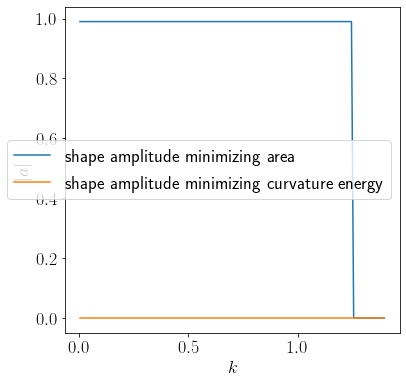

In [14]:
#print(minima_surf_df)
plt.plot([float(k) for k in minima_surf_df.columns], [abs(minima_surf_df.iloc[0,k]) for k in range(len(minima_surf_df.columns))], label="shape amplitude minimizing area")
plt.plot([float(k) for k in minima_curv_df.columns], [abs(minima_curv_df.iloc[0,k]) for k in range(len(minima_curv_df.columns))],label="shape amplitude minimizing curvature energy")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|a|$")

Despite what we may know about the Plateau-Rayleigh instability being at k=1, this is correct; when looking
at the full energy functional the global minimum energy is at a shape $|a|\neq 0$ some way above $k=1$.
For $H_0=0$, curvature energy always least on flat cylinder as expected.

And the energy value $E(a_{min})$:

Text(0, 0.5, 'E')

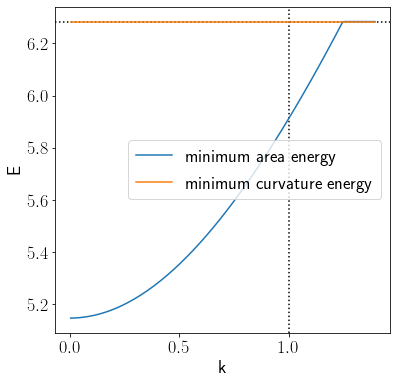

In [15]:
plt.axhline(math.pi*2, color='black', linestyle=':')
plt.axvline(1, color='black', linestyle=':')
plt.plot([float(k) for k in minima_surf_df.columns], [abs(minima_surf_df.loc['E',k]) for k in minima_surf_df.columns], label="minimum area energy")
plt.plot([float(k) for k in minima_curv_df.columns], [abs(minima_curv_df.loc['E',k]) for k in minima_curv_df.columns],label="minimum curvature energy")
plt.legend()
plt.xlabel("k")
plt.ylabel("E")
#plt.ylim(0,10)

Area energy with $\gamma=1$; curvature energy with $\kappa=1$

Let's go through a range of ratios kappa:gamma and find the minimizing amplitude a and energy E at that minimum, for a range of ks

In [16]:
if firsttime:
    minima_total_as={}
    minima_total_Es={}
    gamma=1
    kappas=np.arange(0,1,.01)
    for kappa in kappas:
        minima_total_as_kappa={}
        minima_total_Es_kappa={}
        for k in curvdata.columns:
            curv_energy_vs_a = curvdata.loc[:,k]
            surf_energy_vs_a = surfdata.loc[:,k]
            total_energy_vs_a = gamma*surf_energy_vs_a+kappa/2*curv_energy_vs_a
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_kappa[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_kappa[k]= min_energy
        minima_total_as[kappa]=minima_total_as_kappa
        minima_total_Es[kappa]=minima_total_Es_kappa
    #print(minima_total)
    df_minima_total_as=pd.DataFrame(minima_total_as)
    df_minima_total_Es=pd.DataFrame(minima_total_Es)
    df_minima_total_as.to_csv("chapter2data/minimizing_a_inkappaandk_tmp.csv")
    df_minima_total_Es.to_csv("chapter2data/minimizing_E_inkappaandk_tmp.csv")
else:
    df_minima_total_as=pd.read_csv("chapter2data/minimizing_a_inkappaandk.csv", index_col=0, dtype=float)
    df_minima_total_Es=pd.read_csv("chapter2data/minimizing_E_inkappaandk.csv", index_col=0, dtype=float)

<AxesSubplot:>

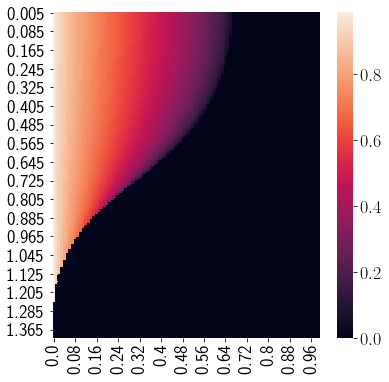

In [17]:
sb.heatmap(df_minima_total_as)

We also want an evenly spaced grid in the inverse paramterization, gamma/kappa

In [18]:
if firsttime:
    minima_total_as_g={}
    minima_total_Es_g={}
    kappa=1
    gammas=np.arange(1,5,.01)
    for gamma in gammas:
        minima_total_as_gamma={}
        minima_total_Es_gamma={}
        for k in curvdata.columns:
            curv_energy_vs_a = curvdata.loc[:,k]
            surf_energy_vs_a = surfdata.loc[:,k]
            total_energy_vs_a = gamma*surf_energy_vs_a+kappa/2*curv_energy_vs_a
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_gamma[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_gamma[k]= min_energy
        minima_total_as_g[gamma]=minima_total_as_gamma
        minima_total_Es_g[gamma]=minima_total_Es_gamma
    df_minima_total_as_g=pd.DataFrame(minima_total_as_g)
    df_minima_total_Es_g=pd.DataFrame(minima_total_Es_g)
    df_minima_total_as_g.to_csv("chapter2data/minimizing_a_ingammaandk_tmp.csv")
    df_minima_total_Es_g.to_csv("chapter2data/minimizing_E_ingammaandk_tmp.csv")
else:
    df_minima_total_as_g=pd.read_csv("chapter2data/minimizing_a_ingammaandk.csv", index_col=0, dtype=float)
    df_minima_total_Es_g=pd.read_csv("chapter2data/minimizing_E_ingammaandk.csv", index_col=0, dtype=float)

<AxesSubplot:>

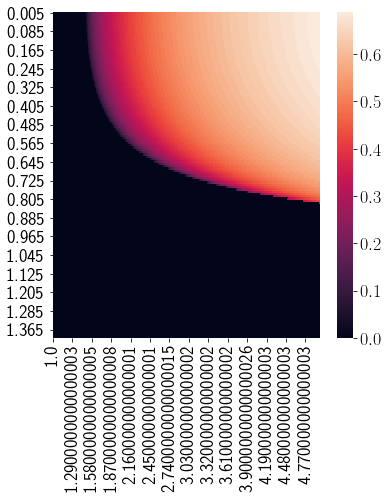

In [19]:
sb.heatmap(df_minima_total_as_g)


Let's make a pretty plot of both views with superimposed pertrubative limit k*

In [20]:
#the lines of section 1, shifted to overlay these grids
y_indices,x_indices = df_minima_total_as.shape
print(df_minima_total_as.shape)
#for lineplot 1 scale date from 0 to .95 to indices 0 to x_indices
lineplot_xs_1= [100*(1/g) for g,kc in zip(gs, kcrits_) if kc is not None]
#for lineplot 1 scale date from 1.395 to 0.005 to indices 0 to y_indices
lineplot_ys_1= [100*(1.395-kc) for kc in kcrits_ if kc is not None]

lineplot_xs_2= [100*(g-1) for g,kc in zip(gs, kcrits_) if kc is not None]
lineplot_ys_2= [100*(1.395-kc) for kc in kcrits_ if kc is not None]

(140, 100)


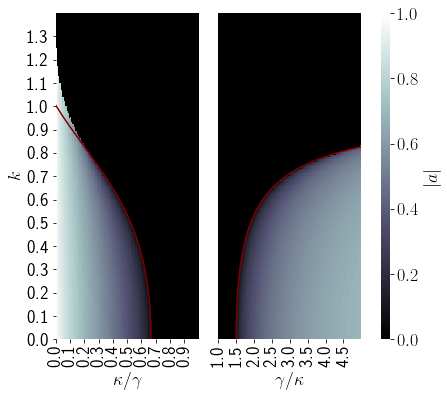

In [21]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1.2,1.2,0.08]}) #the last axis is for colorbar
#ax1.get_shared_y_axes().join(ax1,ax2)
ax1.plot(lineplot_xs_1, lineplot_ys_1, color='maroon')
ax1.set_ylim([0, 100*1.395])
ax1.set_xlim([0, 100*.99])
g1 = sb.heatmap(df_minima_total_as[::-1],cmap="bone",cbar=False,ax=ax1, vmax=1, vmin=0)
g1.set_ylabel(r'$k$')
g1.set_xlabel(r'$\kappa/\gamma$')
g1.set_xticks([n for n in range(0,100,10)])
g1.set_xticklabels([round(.01*n,3) for n in range(0,100,10)])
ax2.plot(lineplot_xs_2, lineplot_ys_2, color='maroon')
g2 = sb.heatmap(df_minima_total_as_g[::-1],cmap="bone",cbar=True, cbar_kws={'label':r'$|a|$'},
                ax=ax2, cbar_ax=axcb, vmax=1, vmin=0)
#g2.set_ylabel('k')
g2.set_xlabel(r'$\gamma/\kappa$')
g2.set_xticks([n for n in range(0,400,50)])
g2.set_xticklabels([round(1+.01*n,3) for n in range(0,400,50)])

g1.set_yticks([n+10 for n in range(0,140,10)])
g1.set_yticklabels([round(1.3-.01*n,3) for n in range(0,140,10)])
g2.set_yticks([])

plt.savefig("chapter2data/numerical_minima_tmp.png")
plt.show()

This plot shows how well the numerical minima in the energy E(a) match up with perturbative
prediction for limit of stability.
Pretty good, except for the overshoot at k=1, kappa=0.  
This is the region of metastability.  It can be explained by looking at surface area alone.

<AxesSubplot:>

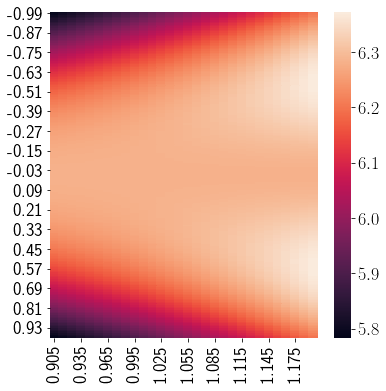

In [22]:
sb.heatmap(surfdata.iloc[:, 90:120])

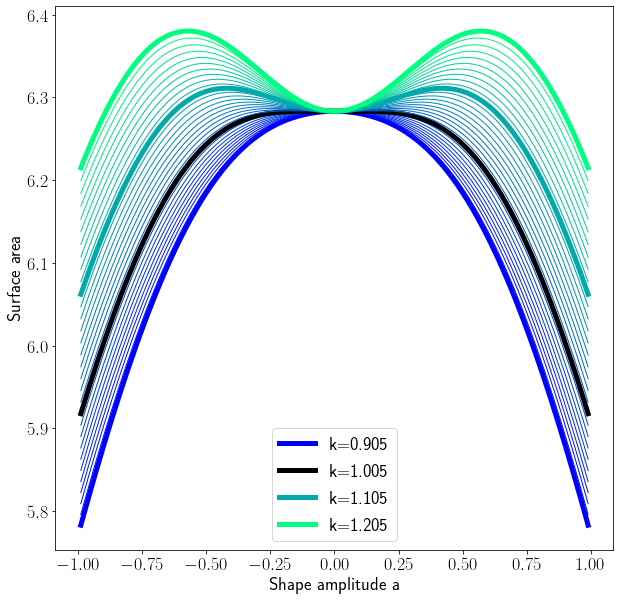

In [23]:
range1=90
range2=121
plt.figure(figsize=(10,10))   
cols = plt.cm.winter([(float(surfdata.columns[k_index])-float(surfdata.columns[range1]))/
                      (float(surfdata.columns[range2-1])-float(surfdata.columns[range1]))  
                      for k_index in range(90,121)])    
for index,k_index in enumerate(range(range1,range2)):
    k_line=surfdata.iloc[:,k_index]
    if k_index%10==0:
        if k_index==100:
            plt.plot(k_line, label="k="+str(surfdata.columns[k_index]), linewidth=5, color='black')
        else:
            plt.plot(k_line, label="k="+str(surfdata.columns[k_index]), linewidth=5, color=cols[index])
    else:
        plt.plot(k_line, linewidth=1,color=cols[index])
plt.xlabel("Shape amplitude a")
plt.ylabel("Surface area")
plt.legend()
#plt.ylim(6.2,6.3)
#plt.xlim(-.1, .1)
#plt.savefig("./chapter2data/surfarea_discrepancy_tmp.png")
plt.show()

We see that for $k \geq 1$, there is a local minimum at a=0, but the global minimum is at $a=1$.
Thus the two indicators of stability (curvature around a=0, searching for global minima) disagree.

## 2.2 spontaneous curvature

We also want plots of numerical results to match the spontaneous curvature results from section 1.
For a 3 chosen values gamma/kappa = 0, 1.5, 10, generate data a_min in a grid in k, H_0.



In [40]:
H0_s=np.arange(-4,4.0001,.05)
ks = np.arange(0.1, 2.3, .1) #have to go higher in k here
kappa=1

In [41]:
gamma = 0 #no surface tension, curvature energy only
firsttime = True
if firsttime:
    minima_total_as={}
    minima_total_Es={}
    for H0 in H0_s:
        minima_total_as_H0={}
        minima_total_Es_H0={}
        for k in ks:
            cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
            curvenergya={}
            for a in a_s:
                energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
                curvenergya[round(a,2)]=energy*k
            total_energy_vs_a = pd.Series(curvenergya)#turn dict to series
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_H0[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_H0[k]= min_energy
        minima_total_as[H0]=minima_total_as_H0
        minima_total_Es[H0]=minima_total_Es_H0
    #print(minima_total)
    df_minima_total_as=pd.DataFrame(minima_total_as)
    df_minima_total_Es=pd.DataFrame(minima_total_Es)
    df_minima_total_as.to_csv("chapter2data/minimizing_a_H0_gamma0.csv")
    df_minima_total_Es.to_csv("chapter2data/minimizing_E_H0_gamma0.csv")
else:
    df_minima_total_as=pd.read_csv("chapter2data/minimizing_a_H0_gamma0.csv", index_col=0, dtype=float)
    df_minima_total_Es=pd.read_csv("chapter2data/minimizing_E_H0_gamma0.csv", index_col=0, dtype=float)

-4.0
-3.95
-3.9000000000000004
-3.8500000000000005
-3.8000000000000007
-3.750000000000001
-3.700000000000001
-3.6500000000000012
-3.6000000000000014
-3.5500000000000016
-3.5000000000000018
-3.450000000000002
-3.400000000000002
-3.3500000000000023
-3.3000000000000025
-3.2500000000000027
-3.200000000000003
-3.150000000000003
-3.100000000000003
-3.0500000000000034
-3.0000000000000036
-2.9500000000000037
-2.900000000000004
-2.850000000000004
-2.8000000000000043
-2.7500000000000044
-2.7000000000000046
-2.650000000000005
-2.600000000000005
-2.550000000000005
-2.5000000000000053
-2.4500000000000055
-2.4000000000000057
-2.350000000000006
-2.300000000000006
-2.250000000000006
-2.2000000000000064
-2.1500000000000066
-2.1000000000000068
-2.050000000000007
-2.000000000000007
-1.9500000000000073
-1.9000000000000075
-1.8500000000000076
-1.8000000000000078
-1.750000000000008
-1.7000000000000082
-1.6500000000000083
-1.6000000000000085
-1.5500000000000087
-1.5000000000000089
-1.450000000000009
-1.40000

<AxesSubplot:>

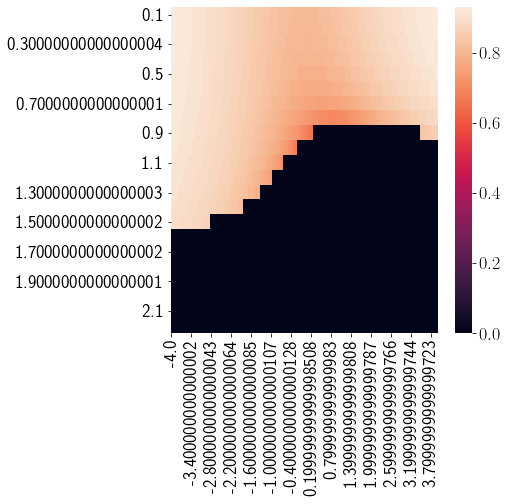

In [45]:
sb.heatmap(df_minima_total_as)

In [43]:
gamma = 1.5 #the critical surface tension
if firsttime:
    minima_total_as={}
    minima_total_Es={}
    for H0 in H0_s:
        minima_total_as_H0={}
        minima_total_Es_H0={}
        for k in ks:
            cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
            curvenergya={}
            for a in a_s:
                energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
                curvenergya[round(a,2)]=energy*k
            total_energy_vs_a = pd.Series(curvenergya)#turn dict to series
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_H0[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_H0[k]= min_energy
        minima_total_as[H0]=minima_total_as_H0
        minima_total_Es[H0]=minima_total_Es_H0
    #print(minima_total)
    df_minima_total_as=pd.DataFrame(minima_total_as)
    df_minima_total_Es=pd.DataFrame(minima_total_Es)
    df_minima_total_as.to_csv("chapter2data/minimizing_a_H0_gamma1p5_tmp.csv")
    df_minima_total_Es.to_csv("chapter2data/minimizing_E_H0_gamma1p5_tmp.csv")
else:
    df_minima_total_as=pd.read_csv("chapter2data/minimizing_a_H0_gamma1p5.csv", index_col=0, dtype=float)
    df_minima_total_Es=pd.read_csv("chapter2data/minimizing_E_H0_gamma1p5.csv", index_col=0, dtype=float)

-4.0
-3.95
-3.9000000000000004
-3.8500000000000005
-3.8000000000000007
-3.750000000000001
-3.700000000000001
-3.6500000000000012
-3.6000000000000014
-3.5500000000000016
-3.5000000000000018
-3.450000000000002
-3.400000000000002
-3.3500000000000023
-3.3000000000000025
-3.2500000000000027
-3.200000000000003
-3.150000000000003
-3.100000000000003
-3.0500000000000034
-3.0000000000000036
-2.9500000000000037
-2.900000000000004
-2.850000000000004
-2.8000000000000043
-2.7500000000000044
-2.7000000000000046
-2.650000000000005
-2.600000000000005
-2.550000000000005
-2.5000000000000053
-2.4500000000000055
-2.4000000000000057
-2.350000000000006
-2.300000000000006
-2.250000000000006
-2.2000000000000064
-2.1500000000000066
-2.1000000000000068
-2.050000000000007
-2.000000000000007
-1.9500000000000073
-1.9000000000000075
-1.8500000000000076
-1.8000000000000078
-1.750000000000008
-1.7000000000000082
-1.6500000000000083
-1.6000000000000085
-1.5500000000000087
-1.5000000000000089
-1.450000000000009
-1.40000

In [44]:
gamma = 10 #a high surface tension
if firsttime:
    minima_total_as={}
    minima_total_Es={}
    for H0 in H0_s:
        minima_total_as_H0={}
        minima_total_Es_H0={}
        for k in ks:
            cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=gamma, intrinsic_curvature=H0)
            curvenergya={}
            for a in a_s:
                energy=cy.calc_surface_energy(amplitude=a) #this is (g*Area + kappa/2 Bending) already
                curvenergya[round(a,2)]=energy*k
            total_energy_vs_a = pd.Series(curvenergya)#turn dict to series
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_H0[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_H0[k]= min_energy
        minima_total_as[H0]=minima_total_as_H0
        minima_total_Es[H0]=minima_total_Es_H0
    #print(minima_total)
    df_minima_total_as=pd.DataFrame(minima_total_as)
    df_minima_total_Es=pd.DataFrame(minima_total_Es)
    df_minima_total_as.to_csv("chapter2data/minimizing_a_H0_gamma10_tmp.csv")
    df_minima_total_Es.to_csv("chapter2data/minimizing_E_H0_gamma10_tmp.csv")
else:
    df_minima_total_as=pd.read_csv("chapter2data/minimizing_a_H0_gamma10.csv", index_col=0, dtype=float)
    df_minima_total_Es=pd.read_csv("chapter2data/minimizing_E_H0_gamma10.csv", index_col=0, dtype=float)

-4.0
-3.95
-3.9000000000000004
-3.8500000000000005
-3.8000000000000007
-3.750000000000001
-3.700000000000001
-3.6500000000000012
-3.6000000000000014
-3.5500000000000016
-3.5000000000000018
-3.450000000000002
-3.400000000000002
-3.3500000000000023
-3.3000000000000025
-3.2500000000000027
-3.200000000000003
-3.150000000000003
-3.100000000000003
-3.0500000000000034
-3.0000000000000036
-2.9500000000000037
-2.900000000000004
-2.850000000000004
-2.8000000000000043
-2.7500000000000044
-2.7000000000000046
-2.650000000000005
-2.600000000000005
-2.550000000000005
-2.5000000000000053
-2.4500000000000055
-2.4000000000000057
-2.350000000000006
-2.300000000000006
-2.250000000000006
-2.2000000000000064
-2.1500000000000066
-2.1000000000000068
-2.050000000000007
-2.000000000000007
-1.9500000000000073
-1.9000000000000075
-1.8500000000000076
-1.8000000000000078
-1.750000000000008
-1.7000000000000082
-1.6500000000000083
-1.6000000000000085
-1.5500000000000087
-1.5000000000000089
-1.450000000000009
-1.40000

# Move to chapter 3

I also want to numerically integrate \int cn^2|A_theta|^2 |Psi_0|^2 dS, the energy from field if it stayed perfectly ordered.  (To first order, the differene in this energy is |alpha|cn^2a^2/2u per unperturbed area). 

In [ ]:
firsttime=True
a_s = np.arange(0, 1, .01)
ks = np.arange(.1, 1.4, .1)
if firsttime:
    straightfieldenergy = {}
    for k in ks:
        straightfieldenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            Ath2sqrtg = lambda z: cy.A_theta(amplitude=a, z=z)**2*cy.sqrt_g_z(amplitude=a, z=z)/cy.sqrt_g_theta(amplitude=a, z=z)
            intAth2, error = scipy.integrate.quad(Ath2sqrtg, 0, 2*math.pi/k) #Ath is real - |A_th| = Ath*Ath/sqrt(gthth)^2
            straightfieldenergya[round(a,2)]=intAth2
        straightfieldenergy[round(k,4)]=straightfieldenergya
    sfdata = pd.DataFrame(straightfieldenergy)
    sfdata.to_csv("chapter2data/straightfieldenergy_tmp.csv")
else:
    sfdata=pd.read_csv("chapter2data/straightfieldenergy.csv", index_col=0)
print(sfdata)


Still need to multiply this by a factor cn^2|sqrt(alpha/u)|^2 (can be taken out of the integral) for the specific field